# Feature engineering for classification and topic modelling of news headlines using open source

As a first task we want to explore the different labels of category of the gathered news items. Missing values will be filled with 'Missing', rare labels will be grouped as 'Other'.
In a later step we want to train a ML model for text classification to predict a category label (supervised learning) as well as clustering the news into different topics (unsupervised learning) and compare them with the labeled categories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sql

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer

# for saving the pipeline
import joblib

# from feature-engine
from feature_engine.imputation import CategoricalImputer, AddMissingIndicator
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

### Load the cleaned data from file

In [2]:
news = pd.read_csv('../eda/news.csv')

In [3]:
news.sort_values(by='date', ascending=False, inplace=True)
news.head()

,date,title,description,category,text,source
67977,2023-10-05 09:28:04,Liveblog: ++ Russland: Stromausfälle nach ukra...,Ein ukrainischer Drohnenangriff hat nach russi...,NaN,NaN,Tagesschau
67976,2023-10-05 09:27:00,USA liefern Kiew beschlagnahmte Munition,Es ist eine Premiere: Die USA haben Munition s...,Iran unterstützt Huthi-Rebellen,NaN,ZDF heute
67975,2023-10-05 09:26:00,Deutschlands Volleyballer entzaubern Italien,Die deutschen Volleyballer landen in der Olymp...,Olympia-Qualifikation,NaN,ZDF heute
67974,2023-10-05 09:21:03,"Rechtsextreme Äußerungen - BGH entscheidet, o...",Der wegen rechtsextremer Äußerungen umstritten...,Aus aller Welt,NaN,Focus
67973,2023-10-05 09:12:58,USA: Mögliche McCarthy-Nachfolger bringen sich...,Nach der Abwahl des Sprechers des US-Repräsent...,NaN,NaN,Tagesschau


### Split the data into train and test set

In [4]:
train, test = train_test_split(news, test_size=0.2, random_state=42)

In [5]:
train.head()

,date,title,description,category,text,source
11502,2022-07-17 04:35:48,Ukraine-Überblick: Selenskyj warnt vor Informa...,"Ukraines Präsident wirft Russland vor, Falschn...",Ausland,NaN,Zeit
47261,2023-04-06 11:18:53,Amoklauf in Hamburg: Vertraute warnten Sportsc...,Hätte der Amoklauf von Hamburg verhindert werd...,Hamburg,NaN,Zeit
8137,2022-07-04 03:18:36,Pandemie: Lauterbach: Schulschließungen nicht ...,Im September läuft die Rechtsgrundlage für Cor...,"Karl Lauterbach, FDP, Schulschließung, Coronav...",NaN,stern
65399,2023-09-14 09:29:15,Tarifeinigung: Spaniens Fußballerinnen beenden...,Die Liga F und die Spielerinnen in Spanien hab...,Sport,NaN,Zeit
10933,2022-07-14 17:34:00,Urteil des EuGH: Thermofenster meist illegal,Abgasreinigung bei Autos darf nicht systematis...,NaN,NaN,taz


In [6]:
test.head()

,date,title,description,category,text,source
36521,2023-01-27 14:42:55,„Die Russen sind nicht weit weg“ - Nach Soleda...,Die meisten der einst 70.000 Einwohner Bachmut...,Ukraine-Krise,NaN,Focus
6172,2022-06-26 18:56:00,"Giffey, die EU und die Documenta: In die Torte...",Berlin fällt auf einen Deepfake-Klitschko rein...,NaN,NaN,taz
57317,2023-06-16 09:22:47,Katholische Kirche: Papst Franziskus verlässt ...,Nach knapp eineinhalb Wochen verlässt Papst Fr...,"Papst Franziskus, Katholische Kirche, Vatikan,...",NaN,stern
64384,2023-09-07 11:09:18,Der neue Botox-Feminismus,Früher waren Schönheits-OPs umstritten. Heute ...,Kommentare,NaN,Welt
9731,2022-07-10 14:55:00,Ukraine-Krieg : Noch hat Kiew den Krieg nicht ...,In den letzten Wochen hat Kiew Niederlage eins...,"Ukraine, Kiew, Moskau, Russland, Streitkräfte,...",NaN,stern


### Replace missing categories by 'Missing'

First we detect the number of missing values in category and replace them with 'Missing'.

In [7]:
print(train['category'].isnull().sum())
print(train['category'].isnull().mean()) # == print(train['category'].isnull().sum() / len(train))

20702
0.3806774300319959


In [8]:
print(test['category'].isnull().sum())
print(test['category'].isnull().mean())

5168
0.3801117975875257


In [9]:
cat_imputer_missing = CategoricalImputer(imputation_method='missing', variables=['category'])
cat_imputer_missing.fit(train)

CategoricalImputer(variables=['category'])

In [10]:
train = cat_imputer_missing.transform(train)
print(train['category'].isnull().sum())

0


In [11]:
test = cat_imputer_missing.transform(test)
print(test['category'].isnull().sum())

0


### Remove rare labels from category and group them as 'Other'

In [12]:
print(train['category'].nunique())
print(train['category'].nunique() / len(train['category']))

15011
0.2760288330697657


In [13]:
print(test['category'].nunique())
print(test['category'].nunique() / len(test['category']))

4013
0.29516034127684615


About 27-29% of the category labels in train and test set have unique values. We will group those categories that are present 
in less than 1% of the observations into a new label 'Other'.

We compute the frequent category labels of the training set and build a list out of them. Then we compare the category labels of both train and test set with the entries in this list and store them accordingly as the orignal label or 'Other' in a new feature 'frequent_category'.

In [14]:
tmp = train.groupby('category')['category'].count() / len(train)
frequent_labels_percentage = tmp[tmp > 0.01]

In [15]:
print(frequent_labels_percentage)

category
Ausland          0.055055
Deutschland      0.050605
Missing          0.380677
News             0.058990
Politik          0.012173
Ukraine-Krise    0.018903
Wirtschaft       0.015796
Name: category, dtype: float64


In [16]:
rle = RareLabelEncoder(tol=0.01, n_categories=1, variables=['category'], replace_with='Other')

# find common labels
rle.fit(train)

# the common labels are stored, we can save the class
# and then use it later :)
rle.encoder_dict_

{'category': ['Missing',
  'News',
  'Ausland',
  'Deutschland',
  'Ukraine-Krise',
  'Wirtschaft',
  'Politik']}

In [17]:
train = rle.transform(train)
train.head()

,date,title,description,category,text,source
11502,2022-07-17 04:35:48,Ukraine-Überblick: Selenskyj warnt vor Informa...,"Ukraines Präsident wirft Russland vor, Falschn...",Ausland,NaN,Zeit
47261,2023-04-06 11:18:53,Amoklauf in Hamburg: Vertraute warnten Sportsc...,Hätte der Amoklauf von Hamburg verhindert werd...,Other,NaN,Zeit
8137,2022-07-04 03:18:36,Pandemie: Lauterbach: Schulschließungen nicht ...,Im September läuft die Rechtsgrundlage für Cor...,Other,NaN,stern
65399,2023-09-14 09:29:15,Tarifeinigung: Spaniens Fußballerinnen beenden...,Die Liga F und die Spielerinnen in Spanien hab...,Other,NaN,Zeit
10933,2022-07-14 17:34:00,Urteil des EuGH: Thermofenster meist illegal,Abgasreinigung bei Autos darf nicht systematis...,Missing,NaN,taz


In [18]:
test = rle.transform(test)
test.head()

,date,title,description,category,text,source
36521,2023-01-27 14:42:55,„Die Russen sind nicht weit weg“ - Nach Soleda...,Die meisten der einst 70.000 Einwohner Bachmut...,Ukraine-Krise,NaN,Focus
6172,2022-06-26 18:56:00,"Giffey, die EU und die Documenta: In die Torte...",Berlin fällt auf einen Deepfake-Klitschko rein...,Missing,NaN,taz
57317,2023-06-16 09:22:47,Katholische Kirche: Papst Franziskus verlässt ...,Nach knapp eineinhalb Wochen verlässt Papst Fr...,Other,NaN,stern
64384,2023-09-07 11:09:18,Der neue Botox-Feminismus,Früher waren Schönheits-OPs umstritten. Heute ...,Other,NaN,Welt
9731,2022-07-10 14:55:00,Ukraine-Krieg : Noch hat Kiew den Krieg nicht ...,In den letzten Wochen hat Kiew Niederlage eins...,Other,NaN,stern


In [19]:
train['category'].value_counts()

category
Other            22177
Missing          20702
News              3208
Ausland           2994
Deutschland       2752
Ukraine-Krise     1028
Wirtschaft         859
Politik            662
Name: count, dtype: int64

In [20]:
test['category'].value_counts()

category
Other            5560
Missing          5168
News              833
Ausland           760
Deutschland       610
Wirtschaft        264
Ukraine-Krise     235
Politik           166
Name: count, dtype: int64

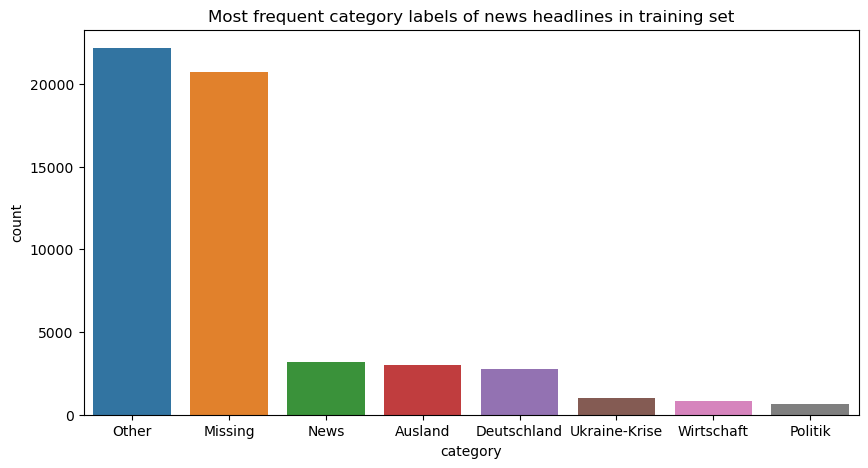

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=train, x='category', order=train['category'].value_counts().index)
plt.title('Most frequent category labels of news headlines in training set')
plt.show()

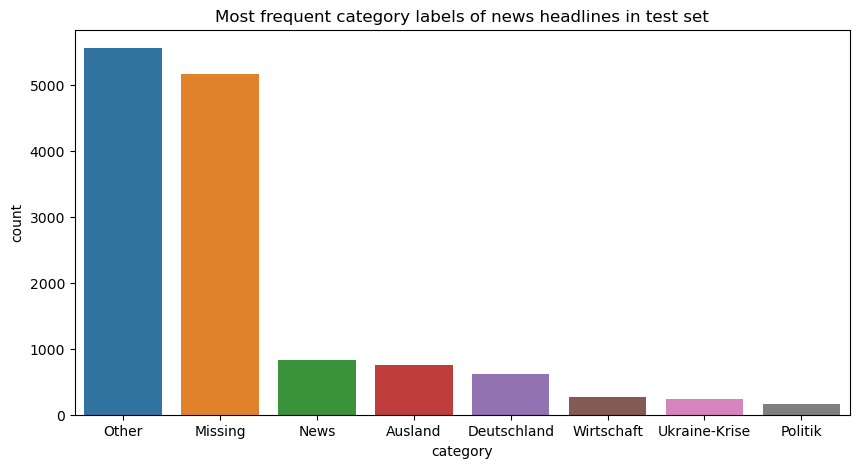

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=test, x='category', order=test['category'].value_counts().index)
plt.title('Most frequent category labels of news headlines in test set')
plt.show()

### Store news

In [23]:
train.to_csv('train_with_open_source.csv', index=False)
test.to_csv('test_with_open_source.csv', index=False)